In [1]:
# !git clone https://github.com/NiteeshSingh/DH602-Anomaly_Detection -q

In [2]:
# cd /kaggle/working/DH602-Anomaly_Detection

## Brain-MRI

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from PIL import Image

import os
import time
import random
import tqdm.notebook as tqdm

import pandas as pd

from models import *
from losses import *

In [2]:
# ROOT_DIR_TRAIN = r"/kaggle/input/brain-tumor-mri-dataset/Training"
ROOT_DIR_TRAIN = r"C:\Users\hp\Desktop\DH602\Project\Coding\Brain-MRIdata\Training"

# ROOT_DIR_TEST = r"/kaggle/input/brain-tumor-mri-dataset/Testing"
ROOT_DIR_TEST = r"C:\Users\hp\Desktop\DH602\Project\Coding\Brain-MRIdata\Testing"


IMAGE_SIZE = (128, 128)
IMAGE_CHANNELS = 1
INPUT_SHAPE = (IMAGE_CHANNELS, *IMAGE_SIZE)
OUTPUT_SHAPE = (IMAGE_CHANNELS, *IMAGE_SIZE)

HIDDEN_DIMS = [32, 64, 128]
LATENT_DIM = 100
PATCH_SIZE = (32, 32)

# OUTPUT_DIR = r"/kaggle/working/output"
OUTPUT_DIR = r"C:\Users\hp\Desktop\DH602\Project\Coding\output"
BATCH_SIZE = 16
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4
SAVE_AFTER_K = 1
VALIDATE_AFTER_K = 1

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def create_data_df(root_dir, mappings=None):
    '''
    1. assumes that there are subfolder of each class in the root directory 
    2. it labels each subfolder as a class and assigns the images in the subfolder to that class
    3. if there are no subfolders, it assumes that the images in the root directory belong to class 0

    it return Dataframe and an dictionary of subfolder ans class labels mappings
    '''

    image_paths = []
    labels = []
    label_mappings = {}

    # check if root has subfolders
    if len(os.listdir(root_dir)) == 0:
        print("No subfolders found, assuming all images in root directory belong to class 0")
        label_mappings[os.path.basename(root_dir)] = 0
        for image_file in os.listdir(root_dir):
            image_path = os.path.join(root_dir, image_file)
            image_paths.append(image_path)
            labels.append(0)
    else:
        for i, subdir in enumerate(os.listdir(root_dir)):
            label_mappings[os.path.basename(subdir)] = i
            subdir_path = os.path.join(root_dir, subdir)
            for image_file in os.listdir(subdir_path):
                image_path = os.path.join(subdir_path, image_file)
                image_paths.append(image_path)
                if mappings:
                    labels.append(mappings[subdir])
                else:
                    labels.append(i)
    if mappings:
        label_mappings = mappings
    return pd.DataFrame({"image_path": image_paths, "label": labels}), label_mappings

train_df, label_mappings = create_data_df(ROOT_DIR_TRAIN)   
test_df, _ = create_data_df(ROOT_DIR_TEST, mappings=label_mappings)

train_df.head(2), test_df.head(2), label_mappings

(                                          image_path  label
 0  C:\Users\hp\Desktop\DH602\Project\Coding\Brain...      0
 1  C:\Users\hp\Desktop\DH602\Project\Coding\Brain...      0,
                                           image_path  label
 0  C:\Users\hp\Desktop\DH602\Project\Coding\Brain...      0
 1  C:\Users\hp\Desktop\DH602\Project\Coding\Brain...      0,
 {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3})

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        image_path, label = (
            self.data_df.iloc[index]["image_path"],
            self.data_df.iloc[index]["label"],
        )
        image = Image.open(image_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# Create a dataset object for the images without tumor
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Grayscale(),
        torchvision.transforms.Resize(IMAGE_SIZE),
        torchvision.transforms.ToTensor(),
    ]
)

# creating no tumor dataset, dataloader
no_tumor_df = train_df[train_df['label'] == label_mappings['notumor']].sample(80).reset_index(drop=True)
no_tumor_dataset = CustomDataset(no_tumor_df, transform=transform)
no_tumor_data_loader = DataLoader(
    dataset=no_tumor_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    # num_workers=4,  # Adjust the number of workers according to your system specifications
    # pin_memory=True if torch.cuda.is_available() else False
)

In [6]:
# creating no glioma dataset, dataloader
glioma_tumor_df = train_df[train_df["label"] == label_mappings["glioma"]].sample(80).reset_index(drop=True)
glioma_tumor_dataset = CustomDataset(glioma_tumor_df, transform=transform)
glioma_tumor_data_loader = DataLoader(
    dataset=no_tumor_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    # num_workers=4,  # Adjust the number of workers according to your system specifications
    # pin_memory=True if torch.cuda.is_available() else False
)

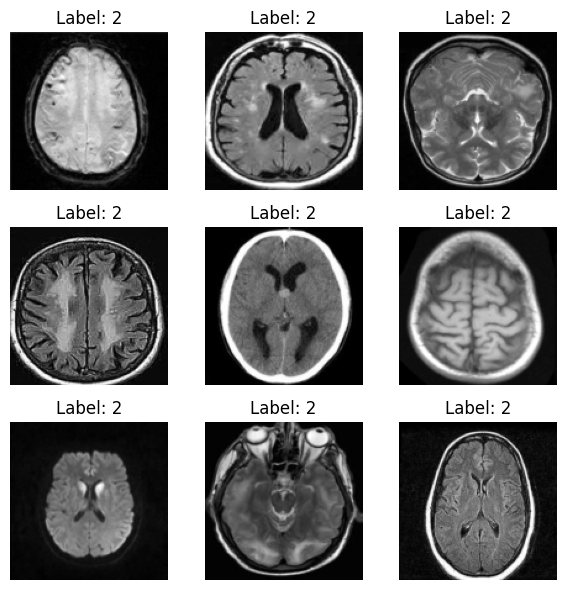

In [7]:
def show_images_grid(dataset, num_images=9, grid_size=(3, 3)):
    fig, axes = plt.subplots(*grid_size, figsize=(2*grid_size[0], 2*grid_size[1]))
    sampled_indices = random.sample(range(len(dataset)), num_images)
    for i, ax in enumerate(axes.flat):
        image, label = dataset[sampled_indices[i]]
        ax.imshow(image.permute(1, 2, 0), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {label}")
    plt.tight_layout()
    plt.show()

# Assuming you have a dataset object named 'custom_dataset'
show_images_grid(no_tumor_dataset, num_images=9, grid_size=(3, 3))

In [26]:
def get_reconstructed_images(model, images, cmap="gray"):
    num_images = images.size(0)
    model.eval()
    with torch.no_grad():
        reconstructed, *rest = model(images)

    # Calculate the absolute difference between the original and reconstructed images
    diff = torch.abs(images - reconstructed)

    # Calculate the anomaly heatmap by summing the absolute differences across channels
    anomaly_heatmap = torch.sum(diff, dim=1, keepdim=True)

    # Plot the original, reconstructed, and anomaly heatmap images side by side
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 2 * num_images))
    for i in range(num_images):
        # Plot original image
        axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu(), cmap=cmap)
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Original")

        # Plot reconstructed image
        axes[i, 1].imshow(reconstructed[i].permute(1, 2, 0).cpu(), cmap=cmap)
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Reconstructed")

        # Plot anomaly heatmap
        axes[i, 2].imshow(anomaly_heatmap[i].squeeze().cpu(), cmap="hot")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Anomaly Heatmap")
    fig.tight_layout()
    return fig

In [9]:
# def get_reconstructed_images_ra(model, images, cmap="gray"):
#     num_images = images.size(0)
#     model.eval()
#     with torch.no_grad():
#         reconstructed, _ = model(images)

#     # Calculate the absolute difference between the original and reconstructed images
#     diff = torch.abs(images - reconstructed)

#     # Calculate the anomaly heatmap by summing the absolute differences across channels
#     anomaly_heatmap = torch.sum(diff, dim=1, keepdim=True)

#     # Plot the original, reconstructed, and anomaly heatmap images side by side
#     fig, axes = plt.subplots(num_images, 3, figsize=(8, 2 * num_images))
#     for i in range(num_images):
#         # Plot original image
#         axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu(), cmap=cmap)
#         axes[i, 0].axis("off")
#         axes[i, 0].set_title("Original")

#         # Plot reconstructed image
#         axes[i, 1].imshow(reconstructed[i].permute(1, 2, 0).cpu(), cmap=cmap)
#         axes[i, 1].axis("off")
#         axes[i, 1].set_title("Reconstructed")

#         # Plot anomaly heatmap
#         axes[i, 2].imshow(anomaly_heatmap[i].squeeze().cpu(), cmap="hot")
#         axes[i, 2].axis("off")
#         axes[i, 2].set_title("Anomaly Heatmap")
#     fig.tight_layout()
#     return fig

### Training

In [10]:
# from ra import *
# model = RA(
#     cdim=1,
#     zdim=LATENT_DIM,
#     channels=HIDDEN_DIMS,
#     image_size=IMAGE_SIZE[0],
#     conditional=False,
#     )
# model

In [11]:
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# criterion = RA_Loss()

In [22]:
model = VAE_Attention(
    input_shape=INPUT_SHAPE,
    hidden_dims=HIDDEN_DIMS,
    latent_dim=LATENT_DIM,
    output_shape=OUTPUT_SHAPE,
)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = RA_Loss()

In [23]:
model

VAE_Attention(
  (encoder): Sequential(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (attention1): SelfAttention(
      (conv_query): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      (conv_key): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      (conv_value): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (attention2): SelfAttention(
      (conv_query): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (conv_key): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
      (conv_value): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (conv3): Conv2d(64, 1

#### decoding model

In [14]:
batch = next(iter(no_tumor_data_loader))[0]
batch.shape

torch.Size([16, 1, 128, 128])

In [19]:
hidden = model.encoder(batch)
hidden.shape

torch.Size([16, 32768])

In [20]:
mu = model.fc_mu(hidden)
logvar = model.fc_logvar(hidden)
z = model.reparameterize(mu, logvar)
z.shape

torch.Size([16, 100])

In [21]:
model.decoder(z).shape

torch.Size([16, 1, 128, 128])

In [17]:
x = model.decoder.fc(z)
print(x.shape)
x = model.decoder.relu(x)
print(x.shape)
x = model.decoder.reshape(x)
print(x.shape)
x = model.decoder.attention1(x)
print(x.shape)

torch.Size([16, 32768])
torch.Size([16, 32768])
torch.Size([16, 128, 16, 16])
torch.Size([16, 128, 16, 16])


In [18]:
HIDDEN_DIMS

[32, 64, 128]

In [34]:
x = model.decoder.conv_transpose1(x)
print(x.shape)
x = model.decoder.bn1(x)
print(x.shape)
x = model.decoder.relu1(x)
print(x.shape)
x = model.decoder.attention2(x)
print(x.shape)

torch.Size([16, 128, 32, 32])
torch.Size([16, 128, 32, 32])
torch.Size([16, 128, 32, 32])


In [20]:
model.spatial_dims

[(128, 128), (64, 64), (32, 32), (16, 16)]

In [11]:
# def train_model_ra(
#     model,
#     train_dataloader,
#     val_dataloader,
#     criterion,
#     optimizer,
#     result_dir,
#     num_epochs=25,
#     save_after_k=5,
#     validate_after_k=5,
# ):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     result_dir_this_run = os.path.join(result_dir, time.strftime("%Y%m%d_%H%M%S"))
#     is_created = os.makedirs(
#         os.path.join(result_dir, time.strftime("%Y%m%d_%H%M%S")), exist_ok=True
#     )
#     model.to(device)
#     history = {"train_loss": [], "val_loss": []}

#     for epoch in range(1, num_epochs + 1):
#         since = time.time()

#         # Training mode
#         model.train()
#         train_loss = 0.0
#         num_batches = len(train_dataloader)
#         with tqdm.tqdm(
#             total=num_batches, desc=f"Epoch {epoch}", unit="batch", leave=False
#         ) as pbar:
#             for batch_idx, batch in enumerate(train_dataloader):
#                 optimizer.zero_grad()
#                 X = batch[0].to(device)
#                 recon_batch, out_data = model(X)
#                 loss, _, _ = criterion(
#                     recon_batch, X, out_data["z_mu"], out_data["z_logvar"]
#                 )
#                 loss.backward()
#                 optimizer.step()

#                 train_loss += loss.item()
#                 avg_loss = train_loss / (batch_idx + 1)
#                 pbar.set_postfix(training_loss=avg_loss)
#                 pbar.update(1)

#         # Calculate mean training loss for the epoch
#         mean_train_loss = train_loss / num_batches
#         history["train_loss"].append(mean_train_loss)

#         # Validation mode
#         validation_done = False
#         if val_dataloader is not None and (epoch % validate_after_k == 0):
#             model.eval()
#             val_loss = 0.0
#             num_val_batches = len(val_dataloader)
#             with tqdm.tqdm(
#                 total=num_val_batches,
#                 desc=f"Validation at Epoch {epoch}",
#                 unit="batch",
#                 leave=False,
#             ) as pbar:
#                 for batch_idx, batch in enumerate(val_dataloader):
#                     X = batch[0].to(device)
#                     # recon_batch, mu, logvar = model(X)
#                     recon_batch, out_data = model(X)
#                     loss, _, _ = criterion(
#                         recon_batch, X, out_data["z_mu"], out_data["z_logvar"]
#                     )
#                     val_loss += loss.item()
#                     avg_loss = val_loss / (batch_idx + 1)
#                     pbar.set_postfix(validation_loss=avg_loss)
#                     pbar.update(1)
#             validation_done = True

#             # Calculate mean validation loss for the epoch
#             mean_val_loss = val_loss / num_val_batches
#             history["val_loss"].append(mean_val_loss)

#         # save model checkpoint
#         if epoch % save_after_k == 0:
#             if val_dataloader is not None:
#                 # Generate reconstructed images using the model
#                 total_samples = len(val_dataloader.dataset)
#                 random_indices = random.sample(range(total_samples), 10)
#                 batch_images = torch.stack(
#                     [val_dataloader.dataset[i][0].to(device) for i in random_indices]
#                 )
#                 batch_images.to(device)
#                 final_image = get_reconstructed_images(model, batch_images)
#                 # Save the sampled images without displaying them in console output
#                 final_image.savefig(
#                     os.path.join(result_dir_this_run, f"sample_images_{epoch}.png"),
#                     bbox_inches="tight",
#                     pad_inches=0,
#                 )
#                 plt.close(final_image)
#             checkpoint = {
#                 "model": model.state_dict(),
#                 "optimizer": optimizer.state_dict(),
#                 "history": history,
#             }

#             torch.save(
#                 checkpoint, os.path.join(result_dir_this_run, f"checkpoint_{epoch}.pth")
#             )

#         # time taken for epoch
#         time_elapsed = time.time() - since
#         print(
#             "Epoch {} completed in {:.0f}m {:.0f}s | ".format(
#                 epoch, time_elapsed // 60, time_elapsed % 60
#             ),
#             end=" ",
#         )
#         if validation_done:
#             print(
#                 f"train loss:{history['train_loss'][-1]} | val loss:{history['val_loss'][-1]}"
#             )
#         else:
#             print(f"train loss:{history['train_loss'][-1]}")

#     return model, history

In [12]:
# trained_model, history = train_model_ra(
#     model,
#     no_tumor_data_loader,
#     glioma_tumor_data_loader,
#     criterion,
#     optimizer,
#     OUTPUT_DIR,
#     num_epochs=NUM_EPOCHS,
#     save_after_k=SAVE_AFTER_K,
#     validate_after_k=VALIDATE_AFTER_K,
# )

### training

In [28]:
def train_model(
    model,
    train_dataloader,
    val_dataloader,
    criterion,
    optimizer,
    result_dir,
    num_epochs=25,
    save_after_k=5,
    validate_after_k=5,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    result_dir_this_run = os.path.join(result_dir, time.strftime("%Y%m%d_%H%M%S"))
    is_created = os.makedirs(
        os.path.join(result_dir, time.strftime("%Y%m%d_%H%M%S")), exist_ok=True
    )
    model.to(device)
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs+1):
        since = time.time()

        # Training mode
        model.train()
        train_loss = 0.0
        num_batches = len(train_dataloader)
        with tqdm.tqdm(total=num_batches, desc=f"Epoch {epoch}", unit="batch", leave=False) as pbar:
            for batch_idx, batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                X = batch[0].to(device)
                recon_batch, mu, logvar = model(X)
                loss, *rest = criterion(recon_batch, X, mu, logvar)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                avg_loss = train_loss / (batch_idx + 1)
                pbar.set_postfix(training_loss=avg_loss)
                pbar.update(1)

        # Calculate mean training loss for the epoch
        mean_train_loss = train_loss / num_batches
        history["train_loss"].append(mean_train_loss)

        # Validation mode
        validation_done = False
        if val_dataloader is not None and (epoch % validate_after_k == 0):
            model.eval()
            val_loss = 0.0
            num_val_batches = len(val_dataloader)
            with tqdm.tqdm(total=num_val_batches, desc=f"Validation at Epoch {epoch}", unit="batch", leave=False) as pbar:
                for batch_idx, batch in enumerate(val_dataloader):
                    X = batch[0].to(device)
                    recon_batch, mu, logvar = model(X)
                    loss, *rest = criterion(recon_batch, X, mu, logvar)
                    val_loss += loss.item()
                    avg_loss = val_loss / (batch_idx + 1)
                    pbar.set_postfix(validation_loss=avg_loss)
                    pbar.update(1)
            validation_done = True

            # Calculate mean validation loss for the epoch
            mean_val_loss = val_loss / num_val_batches
            history["val_loss"].append(mean_val_loss)

        # save model checkpoint
        if epoch % save_after_k == 0:
            if val_dataloader is not None:
                # Generate reconstructed images using the model
                total_samples = len(val_dataloader.dataset)
                random_indices = random.sample(range(total_samples), 10)
                batch_images = torch.stack([val_dataloader.dataset[i][0].to(device) for i in random_indices])
                batch_images.to(device)
                final_image = get_reconstructed_images(model, batch_images)
                # Save the sampled images without displaying them in console output
                final_image.savefig(os.path.join(result_dir_this_run, f"sample_images_{epoch}.png"), bbox_inches='tight', pad_inches=0)
                plt.close(final_image)
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "history": history,
            }

            torch.save(checkpoint, os.path.join(result_dir_this_run, f"checkpoint_{epoch}.pth"))

        # time taken for epoch
        time_elapsed = time.time() - since
        print("Epoch {} completed in {:.0f}m {:.0f}s | ".format(epoch, time_elapsed // 60, time_elapsed % 60), end=' ')
        if validation_done:
            print(f"train loss:{history['train_loss'][-1]} | val loss:{history['val_loss'][-1]}")
        else:
            print(f"train loss:{history['train_loss'][-1]}")

    return model, history

In [ ]:
trained_model, history = train_model(model, no_tumor_data_loader, glioma_tumor_data_loader, criterion, optimizer, OUTPUT_DIR, num_epochs=NUM_EPOCHS, save_after_k=SAVE_AFTER_K, validate_after_k=VALIDATE_AFTER_K)

In [ ]:
# import shutil
# path_of_dir_to_remove = '' 
# shutil.rmtree(path_of_dir_to_remove)

### -

In [ ]:
sample_image_path = '/kaggle/working/output/20240410_113809/sample_images_100.png' #give path to image
Image.open(sample_image_path)

In [ ]:
# device = DEVICE
# val_dataloader = no_tumor_data_loader
# total_samples = len(val_dataloader.dataset)
# random_indices = random.sample(range(total_samples), 10)
# batch_images = torch.stack([val_dataloader.dataset[i][0].to(device) for i in random_indices])
# batch_images.to(device)
# # with torch.no_grad():
# #         reconstructed, _, _ = trained_model(batch_images)
# # type(reconstructed), reconstructed.shape
# final_image = get_reconstructed_images(trained_model, batch_images)

In [ ]:
reconstructed.min(), reconstructed.max()

In [ ]:
scaled_reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min())

In [ ]:
i = 0
plt.imshow(reconstructed[i].permute(1, 2, 0).cpu(), cmap='gray')

In [ ]:
plt.imshow(scaled_reconstructed[i].permute(1, 2, 0).cpu(), cmap='gray')

In [ ]:
batch_images.min(), batch_images.max()